In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import matplotlib.image as mpimg

In [3]:
dfsujo = pd.read_csv('C:/projeto1/analise_exploratoria/data/celular2025.csv', encoding='ISO-8859-1')

In [4]:
dfsujo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Name               930 non-null    object
 1   Model Name                 930 non-null    object
 2   Mobile Weight              930 non-null    object
 3   RAM                        930 non-null    object
 4   Front Camera               930 non-null    object
 5   Back Camera                930 non-null    object
 6   Processor                  930 non-null    object
 7   Battery Capacity           930 non-null    object
 8   Screen Size                930 non-null    object
 9   Launched Price (Pakistan)  930 non-null    object
 10  Launched Price (India)     930 non-null    object
 11  Launched Price (China)     930 non-null    object
 12  Launched Price (USA)       930 non-null    object
 13  Launched Price (Dubai)     930 non-null    object
 14  Launched Y

Limpeza do dataset

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

# 1. Ajustar nomes das colunas
colunas_numericas = ["Mobile Weight", "RAM", "Front Camera", "Back Camera", "Battery Capacity", "Screen Size"]
colunas_precos = ["Launched Price (Pakistan)", "Launched Price (India)", 
                  "Launched Price (China)", "Launched Price (USA)", "Launched Price (Dubai)"]

# Carregar o dataset
dfsujo = pd.read_csv('C:/projeto1/analise_exploratoria/data/celular2025.csv', encoding='ISO-8859-1')

# 2. Limpeza de colunas numéricas
for col in colunas_numericas:
    dfsujo[col] = dfsujo[col].astype(str).str.replace(r'[^0-9.]', '', regex=True)  
    dfsujo[col] = dfsujo[col].apply(lambda x: x if x.count('.') <= 1 else x.replace('.', '', x.count('.') - 1))
    dfsujo[col] = pd.to_numeric(dfsujo[col], errors='coerce')

# 3. Limpeza e conversão de preços para USD
taxas_cambio = {
    "Launched Price (Pakistan)": 1/280,  # 1 PKR = 0.00357 USD
    "Launched Price (India)": 1/83,      # 1 INR = 0.012 USD
    "Launched Price (China)": 1/7.2,     # 1 CNY = 0.139 USD
    "Launched Price (Dubai)": 1/3.67,    # 1 AED = 0.272 USD
    "Launched Price (USA)": 1             # Já está em USD
}

for col in colunas_precos:
    dfsujo[col] = dfsujo[col].astype(str).str.replace(r'[^0-9.]', '', regex=True)  
    dfsujo[col] = pd.to_numeric(dfsujo[col], errors='coerce') * taxas_cambio[col]  # Aplicar conversão

# 4. Criar coluna de preço médio (avg_price)
dfsujo["avg_price"] = dfsujo[colunas_precos].mean(axis=1)

# 5. Substituir valores NaN por 0
dfsujo.fillna(0, inplace=True)

# 6. Remover o outlier identificado (Nokia T21 com preço 39622.0)
dfsujo = dfsujo[dfsujo["Model Name"] != "T21"]

# 7. Função de Web Scraping para buscar câmeras no GSMArena
def obter_valores_camera(modelo):
    url = f'https://www.gsmarena.com/{modelo.replace(" ", "_")}-specs.php'
    response = requests.get(url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Encontrar especificações da câmera
        cameras = {'front': None, 'back': None}
        
        # Procurar pela câmera frontal
        front_camera_spec = soup.find('span', string='Front Camera')
        if front_camera_spec:
            front_value = front_camera_spec.find_next('span')
            if front_value:
                cameras['front'] = front_value.text.strip()

        # Procurar pela câmera traseira
        back_camera_spec = soup.find('span', string='Main Camera')
        if back_camera_spec:
            back_value = back_camera_spec.find_next('span')
            if back_value:
                cameras['back'] = back_value.text.strip()

        return cameras
    
    else:
        return {'front': None, 'back': None}

# 8. Substituindo valores irreais com os dados do Web Scraping
for idx, row in dfsujo.iterrows():
    modelo = row['Model Name']
    
    # Obter as especificações de câmera
    cameras = obter_valores_camera(modelo)
    
    # Se a câmera frontal e traseira forem encontradas, substituímos
    if cameras['front']:
        dfsujo.at[idx, 'Front Camera'] = cameras['front']
    if cameras['back']:
        dfsujo.at[idx, 'Back Camera'] = cameras['back']

# 9. Limitar os valores de câmera a um máximo razoável
limite_frontal = 40  # Máximo de 40MP para a câmera frontal
limite_traseira = 200  # Máximo de 200MP para a câmera traseira

dfsujo['Front Camera'] = dfsujo['Front Camera'].apply(lambda x: np.nan if x > limite_frontal else x)
dfsujo['Back Camera'] = dfsujo['Back Camera'].apply(lambda x: np.nan if x > limite_traseira else x)

# Substituindo NaN por mediana após a limpeza
dfsujo['Front Camera'].fillna(dfsujo['Front Camera'].median(), inplace=True)
dfsujo['Back Camera'].fillna(dfsujo['Back Camera'].median(), inplace=True)

# 10. Salvar dataset limpo e convertido
dfsujo.to_csv('C:/projeto1/analise_exploratoria/data/celular2025_clean.csv', index=False)

print("Dataset limpo, convertido e salvo como 'celular2025_clean.csv'.")


KeyboardInterrupt: 

In [6]:
print(dfsujo.columns)


Index(['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera',
       'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size',
       'Launched Price (Pakistan)', 'Launched Price (India)',
       'Launched Price (China)', 'Launched Price (USA)',
       'Launched Price (Dubai)', 'Launched Year', 'avg_price'],
      dtype='object')


In [7]:
df = pd.read_csv('C:/projeto1/analise_exploratoria/data/celular2025_clean.csv')

In [8]:
df.info

<bound method DataFrame.info of     Company Name            Model Name  Mobile Weight   RAM  Front Camera  \
0          Apple       iPhone 16 128GB          174.0   6.0          12.0   
1          Apple       iPhone 16 256GB          174.0   6.0          12.0   
2          Apple       iPhone 16 512GB          174.0   6.0          12.0   
3          Apple  iPhone 16 Plus 128GB          203.0   6.0          12.0   
4          Apple  iPhone 16 Plus 256GB          203.0   6.0          12.0   
..           ...                   ...            ...   ...           ...   
924         Poco          Pad 5G 128GB          571.0   8.0           8.0   
925         Poco          Pad 5G 256GB          571.0   8.0           8.0   
926      Samsung  Galaxy Z Fold6 256GB          239.0  12.0          16.0   
927      Samsung  Galaxy Z Fold6 512GB          239.0  12.0          16.0   
928      Samsung    Galaxy Z Fold6 1TB          239.0  12.0          16.0   

     Back Camera            Processor  Batt

In [9]:
df.describe()

,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year,avg_price
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,228.011195,9.519914,16.576534,49.744241,5022.747040,9.971507,447.786033,609.781758,531.138620,583.538924,595.462585,2022.193757,554.055622
std,105.199923,37.429609,9.089559,27.493617,1352.266507,44.000080,363.029775,493.593638,384.205226,421.189917,426.670411,1.863072,409.798544
min,135.000000,1.000000,2.000000,5.000000,2000.000000,5.000000,0.000000,72.277108,69.305556,79.000000,81.471390,2014.000000,71.838668
25%,185.000000,6.000000,8.000000,50.000000,4400.000000,6.500000,196.425000,240.951807,236.111111,250.000000,272.479564,2021.000000,245.689001
50%,194.000000,8.000000,16.000000,50.000000,5000.000000,6.670000,303.571429,421.674699,388.888889,449.000000,456.403270,2023.000000,404.479300
75%,208.000000,8.000000,16.000000,50.000000,5065.000000,6.780000,642.853571,902.409639,763.750000,849.000000,871.662125,2024.000000,808.766502
max,732.000000,812.000000,32.000000,200.000000,11200.000000,694.000000,2160.710714,3313.240964,2499.861111,2799.000000,3024.250681,2025.000000,2508.619043


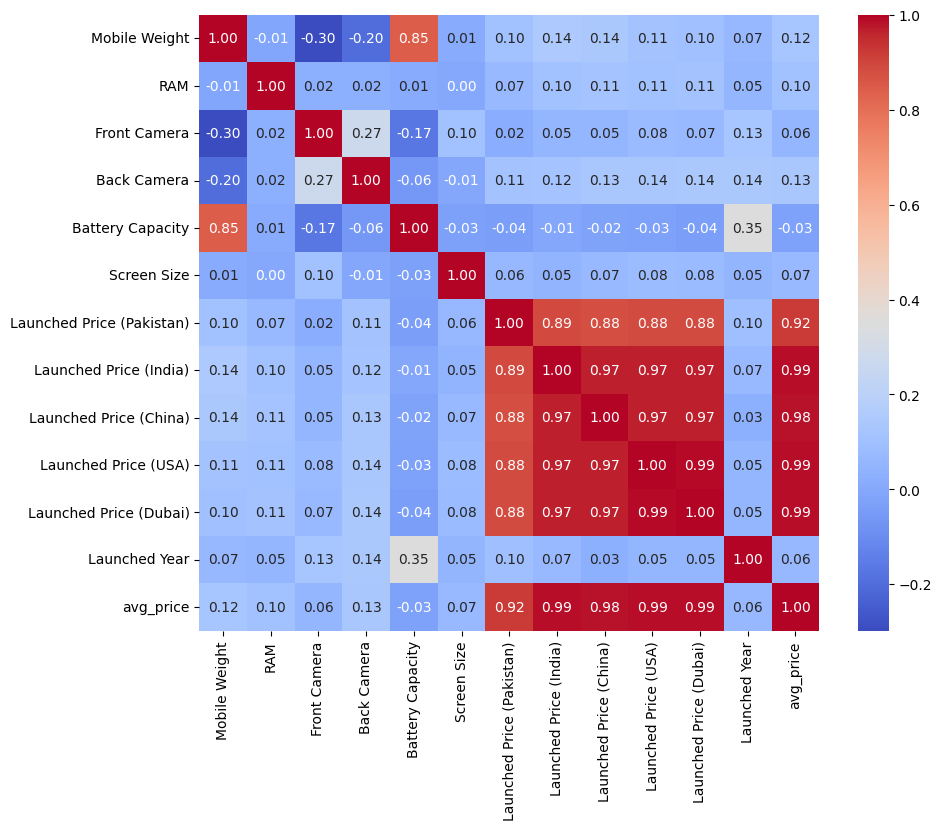

In [10]:
# Selecionando apenas colunas numéricas
df_numerico = df.select_dtypes(include=['float64', 'int64'])

corr = df_numerico.corr()

# Exibindo a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

avg_price_median = df["avg_price"].median()
avg_price_mean = df["avg_price"].mean()

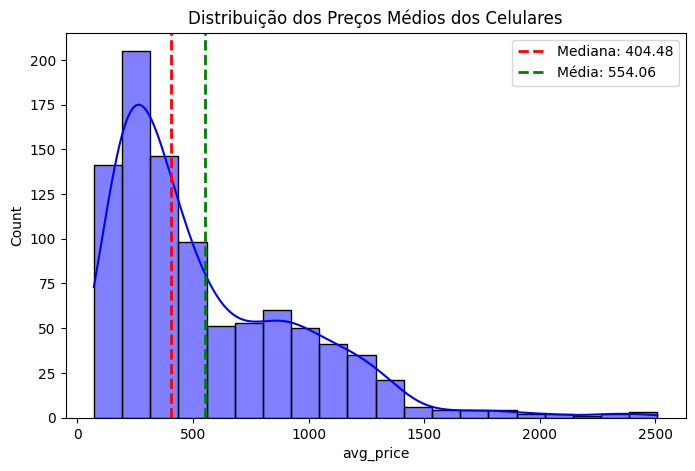

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(df['avg_price'], bins=20, kde=True, color="blue")
plt.axvline(avg_price_median, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: {avg_price_median:.2f}')
plt.axvline(avg_price_mean, color='green', linestyle='dashed', linewidth=2, label=f'Média: {avg_price_mean:.2f}')
plt.legend()
plt.title('Distribuição dos Preços Médios dos Celulares')
plt.show()


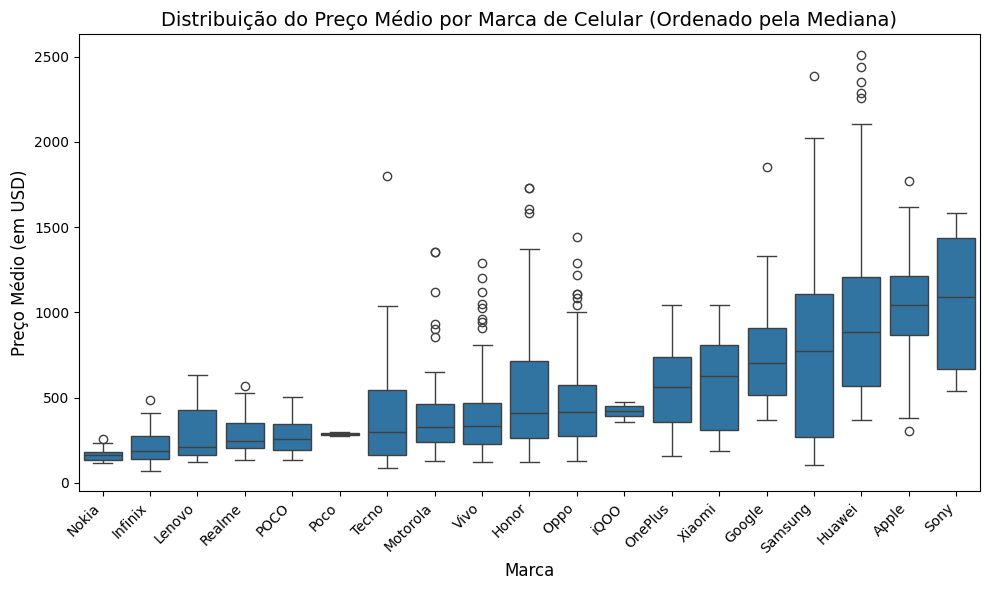

In [12]:
plt.figure(figsize=(10, 6))
order = df.groupby('Company Name')['avg_price'].median().sort_values().index
sns.boxplot(x='Company Name', y='avg_price', data=df, order=order)
plt.xticks(rotation=45, ha="right")
plt.title('Distribuição do Preço Médio por Marca de Celular (Ordenado pela Mediana)', fontsize=14)
plt.xlabel('Marca', fontsize=12)
plt.ylabel('Preço Médio (em USD)', fontsize=12)
plt.tight_layout()
plt.show()

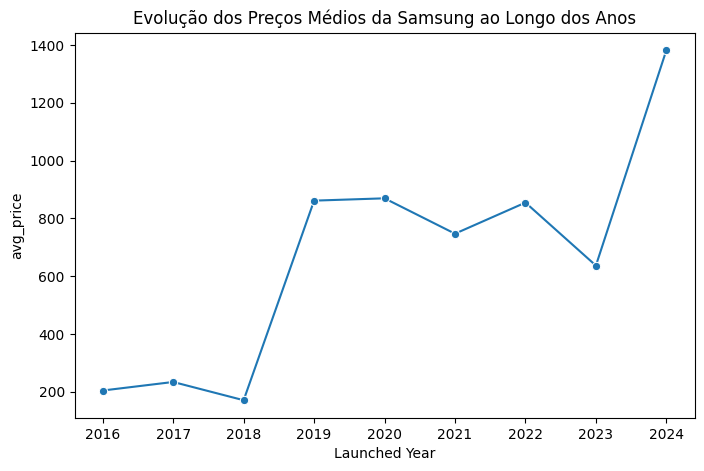

In [15]:
df_samsung = df[df["Company Name"].str.contains("Samsung", case=False, na=False)]

df_samsung_grouped = df_samsung.groupby("Launched Year")["avg_price"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(x="Launched Year", y="avg_price", data=df_samsung_grouped, marker="o")
plt.title("Evolução dos Preços Médios da Samsung ao Longo dos Anos")
plt.show()